### Demo for 3D point cloud registration

Least-squares solution for equal number of points in both clouds.

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
# sample 10 random points in 3D
x = np.random.randn(10,3)

# establish some rotation
rot = R.from_euler('z', 10, degrees=True)
# establish some translation 
t = np.random.randn(1,3)*0.1
# ... and some scaling
scale = 2.0

# get second point cloud as sRx
y = scale*rot.apply(x) + t

In [4]:
print(x.shape)
print(y.shape)

(10, 3)
(10, 3)


### Visualize

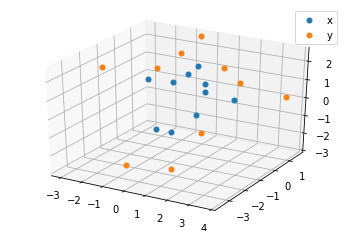

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100) 
ax.plot(x[:,0], x[:,1], x[:,2], '.', markersize=10, label='x')
ax.plot(y[:,0], y[:,1], y[:,2], '.', markersize=10, label='y')
plt.legend();

In [6]:
def register(A, B):
    """
    A and B have to be numpy arrays of the form (3,N), i.e.,
    N points in 3D.
    """
    
    assert A.shape == B.shape

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean (as on slide 6)
    Am = A - centroid_A
    Bm = B - centroid_B

    # compute matrix H (as on slide 12), i.e., the sum over the outer products
    H = Am @ np.transpose(Bm)
    
    # find rotation via SVD and compute R as V*H' (as on slide 12)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # next, as we know rotation, we compute scaling
    scale = np.sqrt(np.sum(np.linalg.norm(Bm.transpose(),axis=1)**2.0)/np.sum(np.linalg.norm(Am.transpose(),axis=1)**2.0))
    
    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -scale * R @ centroid_A + centroid_B

    return R, t, scale

In [8]:
est_rot,est_t,est_scale = register(x.transpose(),y.transpose())

In [9]:
print('Fro. norm diff. in rotation : {:.20f}'.format(np.linalg.norm(est_rot - rot.as_matrix(),'fro')))
print('Abs. diff. in scaling:        {:.20f}'.format(np.abs(scale - est_scale)))
print('Norm. diff in transation:     {:.20f}'.format(np.linalg.norm(t.ravel()-est_t.ravel())))

Fro. norm diff. in rotation : 0.00000000000000049369
Abs. diff. in scaling:        0.00000000000000000000
Norm. diff in transation:     0.00000000000000033337
